In [ ]:
!pip install -e ..
!pip install albumentations
!pip install anytree

Obtaining file:///home/sagemaker-user/mermaid-segmentation
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mermaidseg (pyproject.toml) ... done
  Created wheel for mermaidseg: filename=mermaidseg-0.1.0-0.editable-py3-none-any.whl size=15168 sha256=f253b18a13239bc3e7608214d3ab9fc905e2a9c66a33a8bad1577d584881549e
  Stored in directory: /tmp/pip-ephem-wheel-cache-v43nq3wy/wheels/c3/10/25/8ed498cb59202dbeec283c2e85c7dc9364694a847cbcc29051
Successfully built mermaidseg
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached stringzilla-4.0.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [24]:
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import DataLoader

from anytree import Node, RenderTree

import requests

from matplotlib import pyplot as plt 

from mermaidseg.datasets.dataset import MermaidDataset, Mermaid15Dataset, CoralNetDataset
from mermaidseg.visualization import get_legend_elements

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: Tesla T4


device(type='cuda')

# 2. Data

## 2.1 Mermaid

In [4]:
dataset = MermaidDataset()

In [5]:
len(dataset)

2191

In [6]:
dataset.df_images.head()

,image_id,region_id,region_name
0,00059a47-03b8-47f3-adf6-3ab5616922cf,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0032dba6-8357-42e2-bace-988f99032286,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
2,004ed958-bdd4-453d-83ed-bf773c78bfc8,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,0055fc63-bcce-485b-bb3b-5384c08ad87f,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
4,0072906a-2d45-41ee-84ab-855d5f740028,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


In [7]:
dataset.df_annotations.head()

,id,image_id,point_id,row,col,benthic_attribute_id,benthic_attribute_name,growth_form_id,growth_form_name,updated_on,region_id,region_name
0,adf9f72c-f498-454b-b4c2-d3cb6a2d1c5f,00059a47-03b8-47f3-adf6-3ab5616922cf,44044125-e1b8-4580-8531-acaf18a66935,457,467,30a987e9-b420-4db6-a83a-a1f7cabd14fb,Soft coral,None,None,2025-08-26 14:55:15.009823+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0e97b960-cc38-49ed-91c6-f760f1eff354,00059a47-03b8-47f3-adf6-3ab5616922cf,e8c950a2-c37f-4f5e-8797-3f2d244257b6,457,934,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-26 14:55:15.039272+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
2,1823ca56-edac-459e-b009-46c390f64afe,00059a47-03b8-47f3-adf6-3ab5616922cf,766bd109-c9f7-4489-8215-f2a46ffd9419,457,1401,d9086647-3a82-4634-97bc-6e10347af39b,Bare substrate,None,None,2025-08-26 14:55:15.085659+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,dc9d3b2d-b9f9-4a46-a208-790b5c3b2ec3,00059a47-03b8-47f3-adf6-3ab5616922cf,6aaaea05-f005-4e3e-a9bf-d6702e0b7736,457,1868,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.133907+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
4,9bde5850-bb38-4ca3-88b3-43799f53f0ea,00059a47-03b8-47f3-adf6-3ab5616922cf,bed04244-e299-4eec-b9b7-05e15dbf5a75,457,2335,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.181096+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


In [8]:
image, mask, annotations = dataset[0]

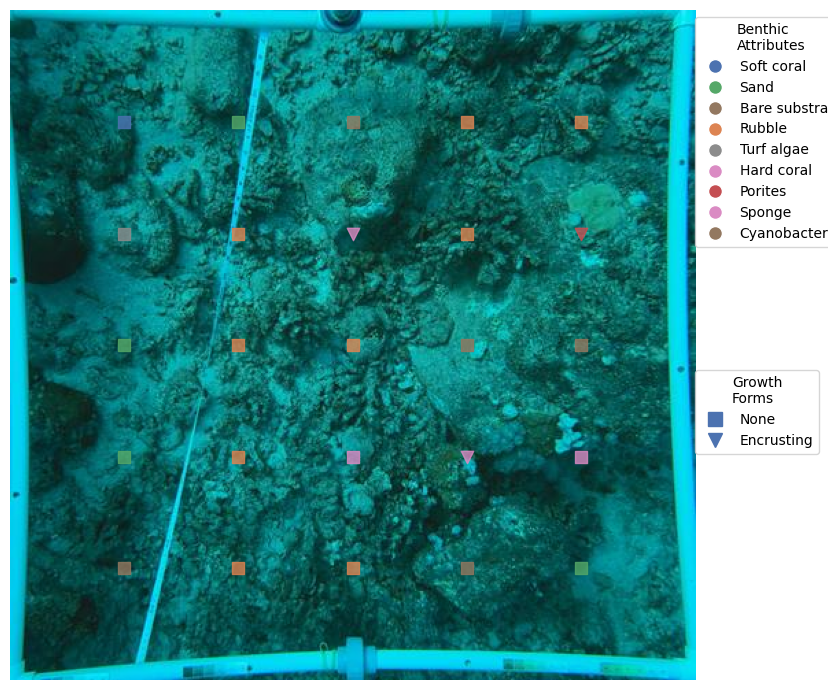

In [9]:
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                marker=annotation["growth_form_marker"], 
                s=80,
                alpha=0.8)

benthic_legend_elements, growth_legend_elements = get_legend_elements(annotations, include_growth_form = True)

first_legend = plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
                            loc='upper left', title='Benthic\nAttributes')
plt.gca().add_artist(first_legend)
plt.legend(handles=growth_legend_elements, bbox_to_anchor=(0.99, 0.4), 
          loc='center left', title='Growth\nForms')

plt.axis("off")
plt.show()

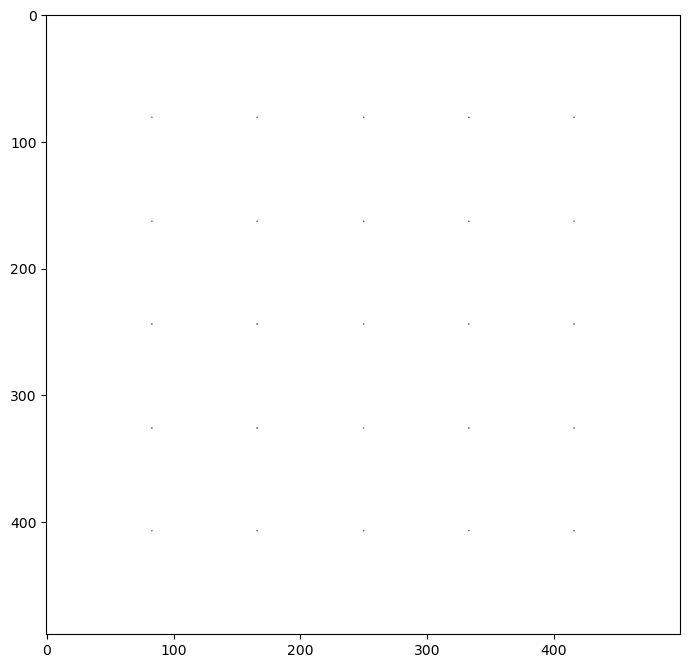

In [10]:
fig, ax = plt.subplots(figsize = (7, 7), layout = "tight")
plt.imshow(np.where(mask>0, mask, np.nan), cmap = "tab10")
plt.show()

In [11]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
len(data_loader)

1095

## 2.2 Mermaid15

### 2.2.1 Setup & Explorations

A subset of the Mermaid dataset with only 15 select classes for experimentation purposes. Labels chosen as most common ones and a few select ones.


In [14]:
dataset.df_annotations["benthic_attribute_name"].value_counts()

benthic_attribute_name
Macroalgae                  10163
Rubble                       9528
Sand                         5958
Porites                      5109
Crustose coralline algae     4669
                            ...  
Gorgonia ventalina              1
Herpolitha                      1
Oulophyllia                     1
Acropora abrolhosensis          1
Tunicate                        1
Name: count, Length: 129, dtype: int64

The annotated classes have a very long tail

/tmp/ipykernel_8248/1991197509.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


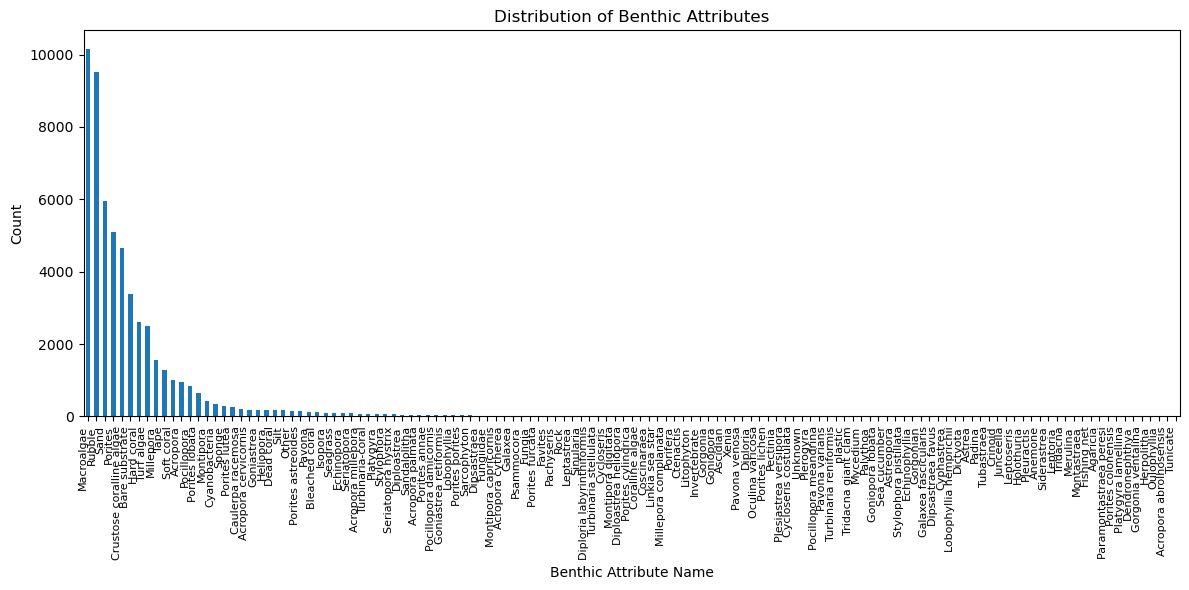

In [56]:
fig, ax = plt.subplots(figsize=(12, 6), layout = "compressed")
dataset.df_annotations["benthic_attribute_name"].value_counts().plot(kind='bar')
plt.title('Distribution of Benthic Attributes')
plt.xlabel('Benthic Attribute Name')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize = 8)
plt.tight_layout()
plt.show()

In [15]:
dataset.df_annotations["benthic_attribute_name"].value_counts().head(15)

benthic_attribute_name
Macroalgae                  10163
Rubble                       9528
Sand                         5958
Porites                      5109
Crustose coralline algae     4669
Bare substrate               3373
Hard coral                   2604
Turf algae                   2494
Millepora                    1553
Tape                         1278
Soft coral                    999
Acropora                      944
Pocillopora                   848
Porites lobata                638
Montipora                     436
Name: count, dtype: int64

In [16]:
# We currently hard code the classes in case the distribution changes with updates of the mermaid annotations data file

classes_mermaid15 = ["Macroalgae", "Rubble", "Sand", "Porites", 
                    "Crustose coralline algae", "Bare substrate", "Hard coral",
                    "Turf algae", "Millepora", "Tape", "Soft coral", "Acropora", 
                    "Pocillopora", "Porites lobata", "Montipora"]

In [20]:
response = requests.get("https://api.datamermaid.org/v1/benthicattributes/")
data = response.json()
benthic_attributes = data['results']

# Keep fetching next pages while there is a 'next' URL
while data['next']:
    response = requests.get(data['next'])
    data = response.json()
    benthic_attributes.extend(data['results'])

In [ ]:
# Create dictionary to store nodes by ID
nodes = {}

# First pass: Create all nodes
for attr in benthic_attributes:
    node_id = attr['id']
    name = attr.get('name', 'Unknown')
    nodes[node_id] = Node(name)

# Second pass: Create parent-child relationships
for attr in benthic_attributes:
    node_id = attr['id']
    parent_id = attr.get('parent')
    if parent_id and parent_id in nodes:
        nodes[node_id].parent = nodes[parent_id]


In [22]:
# Find root nodes (nodes without parents)
root_nodes = [node for node in nodes.values() if node.parent is None]

# Print the tree structure
for root in root_nodes:
    for pre, _, node in RenderTree(root):
        print(f"{pre}{node.name}")

Macroalgae
├── Palisada
├── Padina
│   ├── Padina boergesenii
│   └── Padina antillarum
├── Hypoglossum
├── Acanthophora
│   └── Acanthophora spicifera
├── Tydemania
├── Coelothrix
├── Gelidiopsis
├── Cryptonemia
├── Laurencia
├── Hydroclathrus
├── Gracilaria
│   └── Gracilaria salicornia
├── Eucheuma
├── Neomeris
├── Stypopodium
├── Callithamniaceae
│   └── Spyridia
│       └── Spyridia filamentosa
├── Liagora
├── Ulva
├── Udotea
├── Gelidiella
├── Dichotomosiphonaceae
│   └── Avrainvillea
├── Amansia
├── Bryopsis
├── Penicillus
├── Turbinaria-algae
│   └── Turbinaria turbinata
├── Microdictyon
├── Ventricaria
├── Amphiroa
├── Peyssonneliaceae
│   ├── Peyssonnelia
│   └── Ramicrusta
├── Chlorophyta
├── Cladophora
├── Jania
├── Dictyotaceae
│   ├── Dictyopteris
│   └── Dictyota
├── Green algae
├── Gelidium
├── Cystoseira
├── Lessoniaceae
│   └── Ecklonia
├── Zellera
├── Wrangelia
├── Bonnemaisoniaceae
│   └── Asparagopsis
│       ├── Asparagopsis taxiformis
│       └── Asparagopsis arm

In [25]:
def tree_to_df(root_nodes):
    rows = []
    
    def traverse(node, path):
        # Get the full path from root to current node
        current_path = [ancestor.name for ancestor in node.path]
        # Pad with None if needed
        while len(current_path) < max_depth:
            current_path.append(None)
        rows.append(current_path)
        
        for child in node.children:
            traverse(child, path + [child.name])
    
    # Find maximum depth of the tree
    max_depth = max(node.depth + 1 for root in root_nodes for node in root.descendants)
    
    # Traverse each root node
    for root in root_nodes:
        traverse(root, [root.name])
    
    # Create DataFrame with appropriate column names
    columns = [f'Level_{i}' for i in range(max_depth)]
    df = pd.DataFrame(rows, columns=columns)
    
    return df

# Convert the tree to DataFrame
df_hierarchy = tree_to_df(root_nodes)

In [26]:
df_hierarchy.head()

,Level_0,Level_1,Level_2,Level_3,Level_4,Level_5
0,Macroalgae,None,None,None,None,None
1,Macroalgae,Palisada,None,None,None,None
2,Macroalgae,Padina,None,None,None,None
3,Macroalgae,Padina,Padina boergesenii,None,None,None
4,Macroalgae,Padina,Padina antillarum,None,None,None


In [39]:
for i in range(6):  # We have 6 levels (Level_0 to Level_5)
    level_col = f'Level_{i}'
    level_values = set(df_hierarchy[level_col].values)
    nonlevel_col = df_hierarchy.columns.tolist()
    nonlevel_col.remove(level_col)
    nonlevel_values = set(df_hierarchy[nonlevel_col].values.flatten())
    print(level_values.intersection(nonlevel_values))

set()
{None}
{None}
{None}
{None}
{None}


In [28]:
# Create a dictionary to store class levels
class_levels = {}

for class_name in classes_mermaid15:
    # Find the class in the hierarchy
    for i in range(6):  # We have 6 levels (Level_0 to Level_5)
        level_col = f'Level_{i}'
        mask = df_hierarchy[level_col] == class_name
        if mask.any():
            class_levels[class_name] = i
            break
    else:  # If class is not found in any level
        class_levels[class_name] = None

# Print results
for class_name, level in class_levels.items():
    print(f"{class_name}: Level_{level}")

Macroalgae: Level_0
Rubble: Level_0
Sand: Level_0
Porites: Level_2
Crustose coralline algae: Level_0
Bare substrate: Level_0
Hard coral: Level_0
Turf algae: Level_0
Millepora: Level_2
Tape: Level_1
Soft coral: Level_0
Acropora: Level_2
Pocillopora: Level_2
Porites lobata: Level_3
Montipora: Level_2


In [40]:
for class_name in classes_mermaid15:
    # Find class in hierarchy
    class_found = False
    for node in nodes.values():
        if node.name == class_name:
            print(f"\nTree for {class_name}:")
            # Print the path from root to this node
            path = node.path
            for i, n in enumerate(path):
                print("  " * i + f"└── {n.name}")
            class_found = True
            break
    
    if not class_found:
        print(f"\n{class_name} not found in hierarchy")


Tree for Macroalgae:
└── Macroalgae

Tree for Rubble:
└── Rubble

Tree for Sand:
└── Sand

Tree for Porites:
└── Hard coral
  └── Poritidae
    └── Porites

Tree for Crustose coralline algae:
└── Crustose coralline algae

Tree for Bare substrate:
└── Bare substrate

Tree for Hard coral:
└── Hard coral

Tree for Turf algae:
└── Turf algae

Tree for Millepora:
└── Hard coral
  └── Milleporidae
    └── Millepora

Tree for Tape:
└── Other
  └── Tape

Tree for Soft coral:
└── Soft coral

Tree for Acropora:
└── Hard coral
  └── Acroporidae
    └── Acropora

Tree for Pocillopora:
└── Hard coral
  └── Pocilloporidae
    └── Pocillopora

Tree for Porites lobata:
└── Hard coral
  └── Poritidae
    └── Porites
      └── Porites lobata

Tree for Montipora:
└── Hard coral
  └── Acroporidae
    └── Montipora


In [42]:
classes_mermaid15

['Macroalgae',
 'Rubble',
 'Sand',
 'Porites',
 'Crustose coralline algae',
 'Bare substrate',
 'Hard coral',
 'Turf algae',
 'Millepora',
 'Tape',
 'Soft coral',
 'Acropora',
 'Pocillopora',
 'Porites lobata',
 'Montipora']

In [44]:
def visualize_benthic_hierarchy(classes_mermaid15, nodes, print_counts=False):
    # Build the actual tree structure for our classes
    tree_structure = {}
    
    # First, collect all paths for our classes
    class_paths = {}
    for class_name in classes_mermaid15:
        for node in nodes.values():
            if node.name == class_name:
                class_paths[class_name] = [n.name for n in node.path]
                break
    
    # Build a proper tree structure
    def add_to_tree(path, tree_dict, level=0):
        if level >= len(path):
            return
        
        current_node = path[level]
        if current_node not in tree_dict:
            tree_dict[current_node] = {'children': {}, 'count': 0, 'level': level}
        
        # If this is a leaf node (one of our target classes), increment count
        if level == len(path) - 1 and path[-1] in classes_mermaid15:
            tree_dict[current_node]['count'] += 1
        
        # Recursively add the rest of the path
        if level < len(path) - 1:
            add_to_tree(path, tree_dict[current_node]['children'], level + 1)
    
    # Add all paths to the tree
    root_tree = {}
    for class_name, path in class_paths.items():
        add_to_tree(path, root_tree)
    
    # Count propagation: parent nodes should show count of all children
    def propagate_counts(tree_dict):
        for node_name, node_data in tree_dict.items():
            if node_data['children']:
                # This node has children, so propagate their counts up
                child_count = propagate_counts(node_data['children'])
                if child_count > 0:
                    node_data['count'] = child_count
            # Return the count for this subtree
            total = node_data['count']
            for child_data in node_data['children'].values():
                total += child_data['count']
            node_data['count'] = total
        return sum(node_data['count'] for node_data in tree_dict.values())
    
    propagate_counts(root_tree)
    
    # Print the tree structure
    def print_tree(tree_dict, indent=0):
        for node_name, node_data in sorted(tree_dict.items()):
            count_str = f" ({node_data['count']})" if print_counts and node_data['count'] > 0 else ""
            print("  " * indent + f"└── {node_name}{count_str}")
            
            if node_data['children']:
                print_tree(node_data['children'], indent + 1)
    
    print_tree(root_tree)

# Visualize the hierarchy
visualize_benthic_hierarchy(classes_mermaid15, nodes)

└── Bare substrate
└── Crustose coralline algae
└── Hard coral
  └── Acroporidae
    └── Acropora
    └── Montipora
  └── Milleporidae
    └── Millepora
  └── Pocilloporidae
    └── Pocillopora
  └── Poritidae
    └── Porites
      └── Porites lobata
└── Macroalgae
└── Other
  └── Tape
└── Rubble
└── Sand
└── Soft coral
└── Turf algae


Creating scipy-based dendrogram:


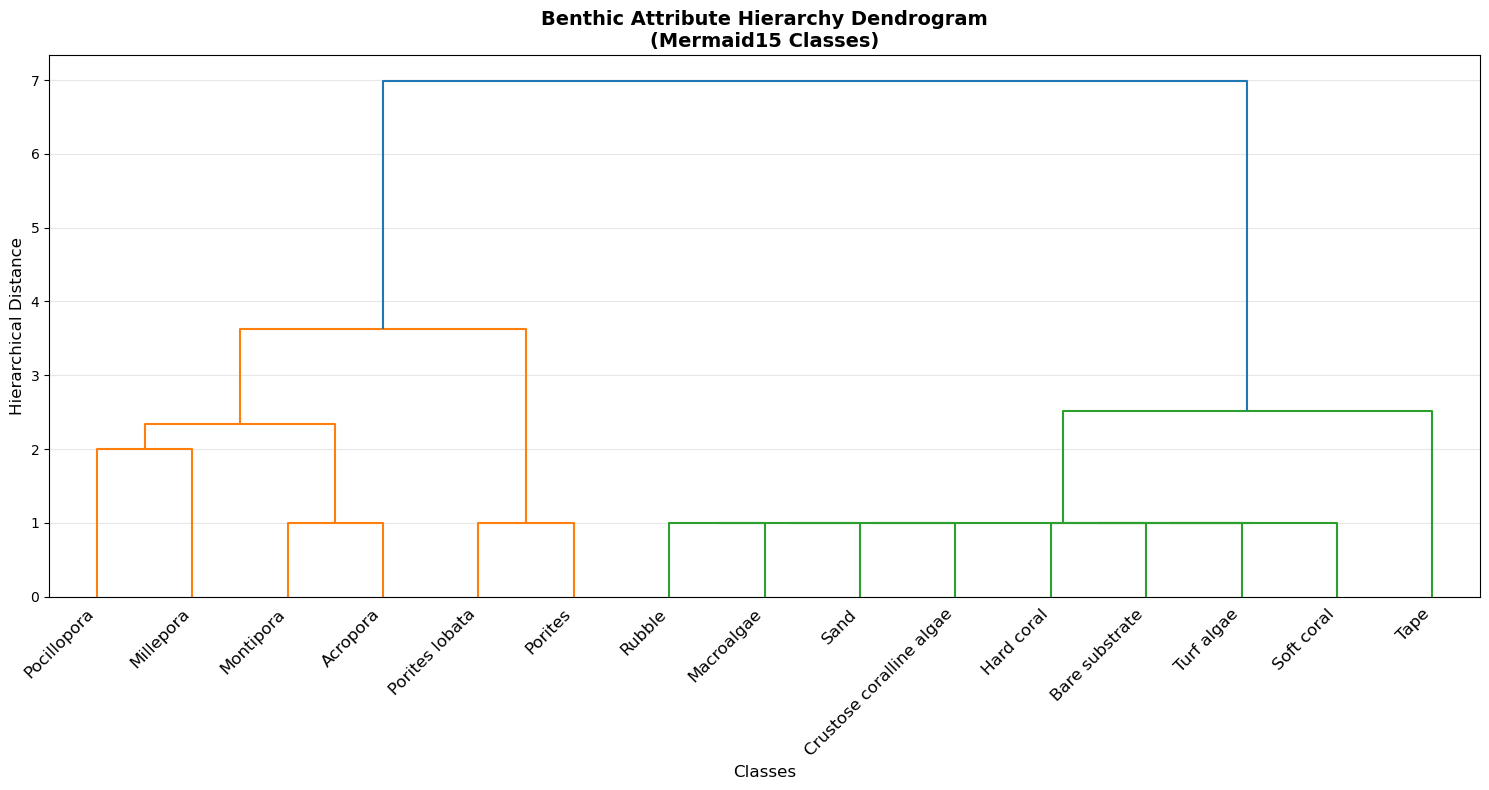

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Benthic Attribute Hierarchy Dendrogram\n(Mermaid15 Classes)'}, xlabel='Classes', ylabel='Hierarchical Distance'>,
 array([[ 5.        ,  6.        ,  1.        ,  2.        ],
        [ 7.        , 15.        ,  1.        ,  3.        ],
        [10.        , 16.        ,  1.        ,  4.        ],
        [ 0.        ,  1.        ,  1.        ,  2.        ],
        [ 2.        , 18.        ,  1.        ,  3.        ],
        [ 4.        , 19.        ,  1.        ,  4.        ],
        [ 3.        , 13.        ,  1.        ,  2.        ],
        [17.        , 20.        ,  1.        ,  8.        ],
        [11.        , 14.        ,  1.        ,  2.        ],
        [ 8.        , 12.        ,  2.        ,  2.        ],
        [23.        , 24.        ,  2.34520788,  4.        ],
        [ 9.        , 22.        ,  2.51661148,  9.        ],
        [21.        , 25.        ,  3.62859018,  6.        ],
        [26.     

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import pandas as pd

def create_proper_dendrogram(classes_mermaid15, nodes, figsize=(15, 8)):
    """Create a proper dendrogram using scipy's hierarchical clustering"""
    
    # First, collect all paths for our classes
    class_paths = {}
    for class_name in classes_mermaid15:
        for node in nodes.values():
            if node.name == class_name:
                class_paths[class_name] = [n.name for n in node.path]
                break
    
    # Create a distance matrix based on hierarchical relationships
    # Classes that share more common ancestors should be closer
    def calculate_distance(path1, path2):
        # Find common prefix length
        common_length = 0
        for i in range(min(len(path1), len(path2))):
            if path1[i] == path2[i]:
                common_length += 1
            else:
                break
        
        # Distance is inversely related to common ancestry
        # More shared ancestors = smaller distance
        max_depth = max(len(path1), len(path2))
        distance = max_depth - common_length
        return distance
    
    # Build distance matrix
    class_list = list(class_paths.keys())
    n_classes = len(class_list)
    distance_matrix = np.zeros((n_classes, n_classes))
    
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j:
                distance_matrix[i, j] = calculate_distance(
                    class_paths[class_list[i]], 
                    class_paths[class_list[j]]
                )
    
    # Convert to condensed distance matrix for linkage
    condensed_distances = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distances, method='ward')
    
    # Create the dendrogram
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create dendrogram with custom colors
    dend = dendrogram(
        linkage_matrix,
        labels=class_list,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True,
        ax=ax
    )
    
    # Customize the plot
    ax.set_title('Benthic Attribute Hierarchy Dendrogram\n(Mermaid15 Classes)', 
                fontsize=14, weight='bold')
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Hierarchical Distance', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax, linkage_matrix


# Create both versions
print("Creating scipy-based dendrogram:")
create_proper_dendrogram(classes_mermaid15, nodes)

Original dataset as of 22.09.2025 has 54775 annotations across 2191 images

In [53]:
dataset.df_annotations.shape, dataset.df_annotations["image_id"].nunique()

((54775, 12), 2191)

Subset of dataset has 50594 images across 5189 images

In [54]:
df_annotations15 = dataset.df_annotations[dataset.df_annotations["benthic_attribute_name"].apply(lambda x: x in classes_mermaid15)]
df_annotations15.shape, df_annotations15["image_id"].nunique()

((50594, 12), 2189)

### 2.2.2 Load Data

In [73]:
dataset = Mermaid15Dataset(padding = 3)

In [58]:
len(dataset)

2189

In [59]:
dataset.df_images.head()

,image_id,region_id,region_name
0,00059a47-03b8-47f3-adf6-3ab5616922cf,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0032dba6-8357-42e2-bace-988f99032286,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
2,004ed958-bdd4-453d-83ed-bf773c78bfc8,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,0055fc63-bcce-485b-bb3b-5384c08ad87f,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
4,0072906a-2d45-41ee-84ab-855d5f740028,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


In [60]:
dataset.df_annotations.head()

,id,image_id,point_id,row,col,benthic_attribute_id,benthic_attribute_name,growth_form_id,growth_form_name,updated_on,region_id,region_name
0,adf9f72c-f498-454b-b4c2-d3cb6a2d1c5f,00059a47-03b8-47f3-adf6-3ab5616922cf,44044125-e1b8-4580-8531-acaf18a66935,457,467,30a987e9-b420-4db6-a83a-a1f7cabd14fb,Soft coral,None,None,2025-08-26 14:55:15.009823+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0e97b960-cc38-49ed-91c6-f760f1eff354,00059a47-03b8-47f3-adf6-3ab5616922cf,e8c950a2-c37f-4f5e-8797-3f2d244257b6,457,934,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-26 14:55:15.039272+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
2,1823ca56-edac-459e-b009-46c390f64afe,00059a47-03b8-47f3-adf6-3ab5616922cf,766bd109-c9f7-4489-8215-f2a46ffd9419,457,1401,d9086647-3a82-4634-97bc-6e10347af39b,Bare substrate,None,None,2025-08-26 14:55:15.085659+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,dc9d3b2d-b9f9-4a46-a208-790b5c3b2ec3,00059a47-03b8-47f3-adf6-3ab5616922cf,6aaaea05-f005-4e3e-a9bf-d6702e0b7736,457,1868,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.133907+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
4,9bde5850-bb38-4ca3-88b3-43799f53f0ea,00059a47-03b8-47f3-adf6-3ab5616922cf,bed04244-e299-4eec-b9b7-05e15dbf5a75,457,2335,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.181096+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific


In [74]:
image, mask, annotations = dataset[0]

In [69]:
annotations

,point_id,row,col,benthic_attribute_id,benthic_attribute_name,growth_form_id,growth_form_name,benthic_color
0,44044125-e1b8-4580-8531-acaf18a66935,81,83,30a987e9-b420-4db6-a83a-a1f7cabd14fb,Soft coral,None,None,#4c72b0
1,e8c950a2-c37f-4f5e-8797-3f2d244257b6,81,166,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,#55a868
2,766bd109-c9f7-4489-8215-f2a46ffd9419,81,250,d9086647-3a82-4634-97bc-6e10347af39b,Bare substrate,None,None,#937860
3,6aaaea05-f005-4e3e-a9bf-d6702e0b7736,81,333,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,#dd8452
4,bed04244-e299-4eec-b9b7-05e15dbf5a75,81,416,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,#dd8452
5,876e2d4d-1450-472e-86b4-625b66d85496,163,83,20090bf4-868e-431b-974c-ab9be5bbdb5f,Turf algae,None,None,#8c8c8c
6,0fd0e8e6-4a45-4a9a-8e99-fae312c5edc6,163,166,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,#dd8452
7,20c28723-9ede-4ab5-b0a9-918b40e4a67c,163,250,350e9eb4-5e6b-48f5-aeb8-0bfdf023bf1c,Hard coral,b406252b-c160-4fd6-b7f9-f61d5e2779a5,Encrusting,#da8bc3
8,54758818-ce97-440d-8916-57535db5fc3d,163,333,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,#dd8452
9,3794b6ba-af3d-4b90-8a9e-e76bd8d3b73e,163,416,2b55697f-f26e-433e-9070-f1fe9748bf7b,Porites,b406252b-c160-4fd6-b7f9-f61d5e2779a5,Encrusting,#c44e52


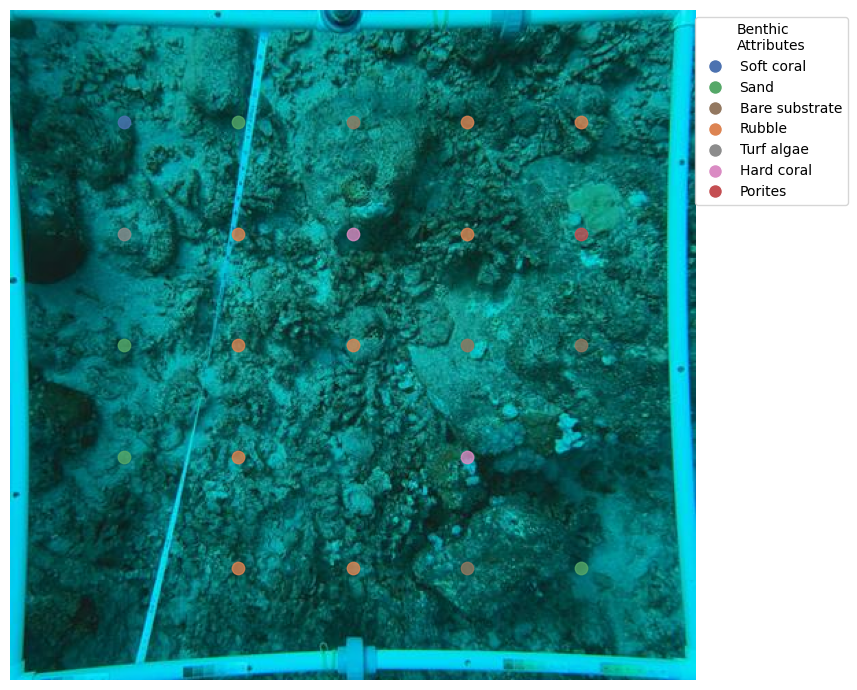

In [75]:
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                marker="o", 
                s=80,
                alpha=0.8)

benthic_legend_elements = get_legend_elements(annotations)

plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
          loc='upper left', title='Benthic\nAttributes')
plt.axis("off")
plt.show()

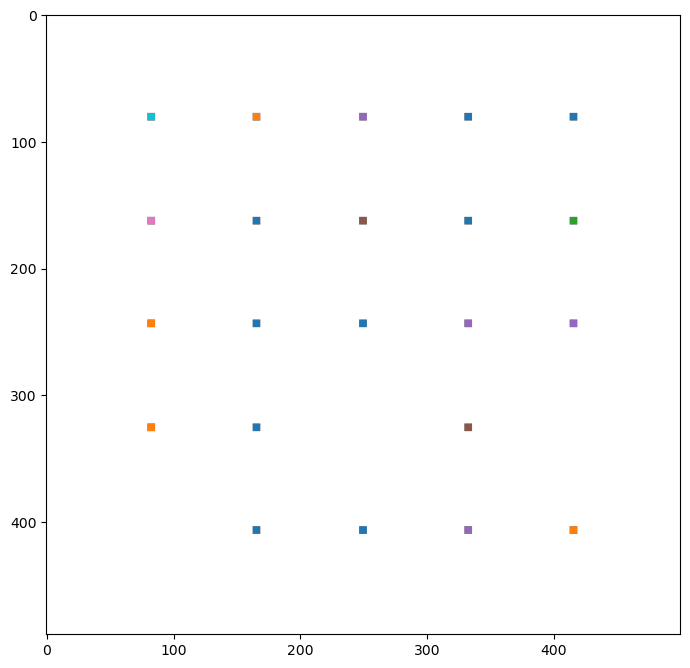

In [76]:
fig, ax = plt.subplots(figsize = (7, 7), layout = "tight")
plt.imshow(np.where(mask>0, mask, np.nan), cmap = "tab10")
plt.show()

In [ ]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
len(data_loader)

1095

## 2.3 CoralNet

In [16]:
dataset = CoralNetDataset(source_ids=[5027, 23, 3329])

Initialize CoralNet to Mermaid LabelMapping
Reading annotations from sources


3it [00:01,  1.78it/s]


In [17]:
len(dataset)

794

In [18]:
dataset.df_images.head()

,source_id,image_id
0,5027,4202593
1,5027,4202594
2,5027,4202595
3,5027,4202596
4,5027,4202597


In [19]:
dataset.df_annotations.head()

,source_id,image_id,row,col,benthic_attribute_name
0,5027,4202593,57,313,None
1,5027,4202593,136,1023,None
2,5027,4202593,299,755,None
3,5027,4202593,254,909,None
4,5027,4202593,380,1522,None


In [20]:
image, mask, annotations = dataset[0]

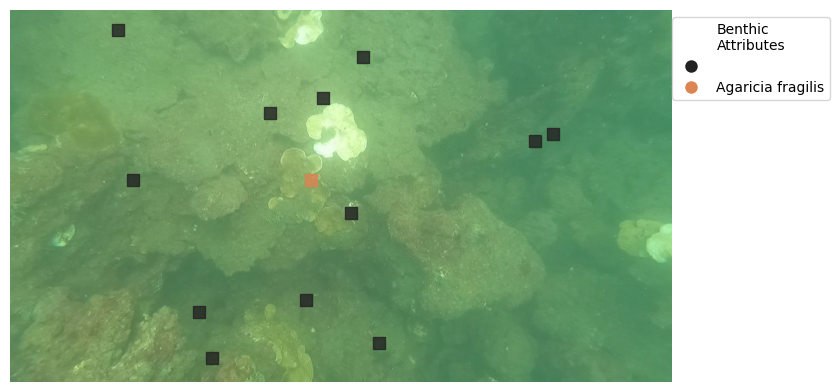

In [24]:
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                marker="s", 
                s=80,
                alpha=0.8)

benthic_legend_elements = get_legend_elements(annotations)

plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
          loc='upper left', title='Benthic\nAttributes')
plt.axis("off")
plt.show()

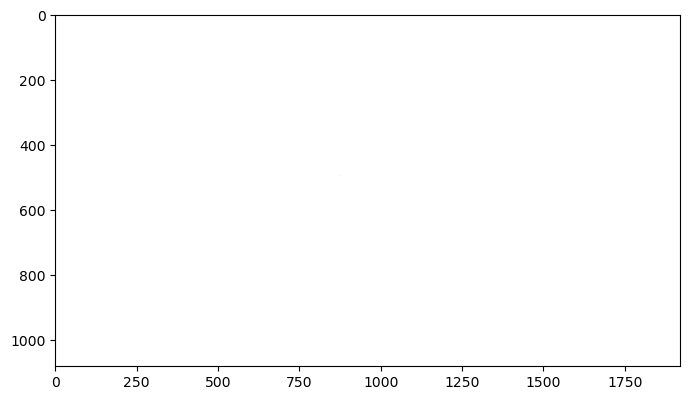

In [25]:
fig, ax = plt.subplots(figsize = (7, 7), layout = "tight")
plt.imshow(np.where(mask>0, mask, np.nan), cmap = "tab10")
plt.show()

In [26]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
len(data_loader)

397